In [1]:
import torch
from fastai.text.all import *

%matplotlib inline

In [2]:
class VocabType(Enum):
    PRETRAINED = 'pretrained'
    CUSTOM = 'custom'

In [3]:
VOCAB_TYPE = VocabType.PRETRAINED

# Fine-tune language model

In [4]:
model_path = untar_data(URLs.WT103_FWD)
model_path.ls()

(#5) [Path('/home/ubuntu/.fastai/data/wt103-fwd/itos_wt103.pkl'),Path('/home/ubuntu/.fastai/data/wt103-fwd/itos_imdb_customvocab.pkl'),Path('/home/ubuntu/.fastai/data/wt103-fwd/models'),Path('/home/ubuntu/.fastai/data/wt103-fwd/lstm_fwd.pth'),Path('/home/ubuntu/.fastai/data/wt103-fwd/itos_imdb_CUSTOM.pkl')]

In [5]:
import pickle

with open(model_path/'itos_wt103.pkl', 'rb') as f:
    wt103_vocab = pickle.load(f)

display(wt103_vocab[:20])
len(wt103_vocab)

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 '=',
 '"',
 'was']

60000

## Prepare dataset for training language model

In [6]:
class LimitedVocabNumericalize(Numericalize):
    def __init__(self, target_vocab, min_freq=3, max_vocab=60000, special_toks=None):
        super().__init__(vocab=None, min_freq=min_freq, max_vocab=max_vocab, special_toks=special_toks)
        self.target_vocab = target_vocab[:max_vocab]

    def setups(self, dsets):
        super().setups(dsets)
        max_vocab = len(self.vocab)
        vocab_set = set(self.vocab)
        target_vocab_set = set(self.target_vocab)
        print(f'Vocab size: {max_vocab}')
        print (f'[LimitedVocabNumericalize] Not present in target: {len(vocab_set.difference(target_vocab_set))}')
        print (f'[LimitedVocabNumericalize] Present only in target: {len(target_vocab_set.difference(vocab_set))}')

        final_o2i = {}      
        free_ids = set(i for i in range(max_vocab))

        shared_tokens = vocab_set.intersection(target_vocab_set)
        print(f'Shared tokens: {len(shared_tokens)}')
        for tok in shared_tokens:
            i = self.o2i[tok]
            free_ids.remove(i)
            final_o2i[tok] = i
        print(f'Remaining ids: {len(free_ids)}')
        
        custom_tokens = vocab_set.difference(target_vocab_set)
        print(f'Custom tokens: {len(custom_tokens)}')
        for tok in custom_tokens:
            i = free_ids.pop()
            final_o2i[tok] = i

        print(f'New vocab diff: {set(final_o2i).difference(vocab_set)}')
        
        self.o2i = defaultdict(int, final_o2i)
        self.vocab = [None] * max_vocab
        for k, v in self.o2i.items():
            self.vocab[v] = k


# tokenizer=TokenizeWithRules(WordTokenizer(), tok_rules)
# num = LimitedVocabNumericalize(wt103_vocab, min_freq=2, max_vocab=16_000, special_toks=tokenizer.tok.special_toks)
# x_tfms = [
#     Tokenizer.from_folder(dataset_path, tok=tokenizer, rules=[]),
#     num
# ]

# lm_files = get_text_files(dataset_path, folders=['unsup'])
# lm_files = lm_files[:1000]

# lm_splits = RandomSplitter(valid_pct=0.1)(lm_files)
# lm_dsets = Datasets(lm_files, [x_tfms], splits = lm_splits, dl_type=LMDataLoader)

In [7]:
dataset_path = untar_data(URLs.IMDB)

if VOCAB_TYPE == VocabType.CUSTOM:
    print('Learning vocab from stratch')
    num = Numericalize(max_vocab=16_000)
else:
    print('Using WT103 model vocab')
    num = LimitedVocabNumericalize(target_vocab=wt103_vocab, max_vocab=16_000)

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    num
]

Using WT103 model vocab


In [8]:
lm_files = get_text_files(dataset_path, folders=['unsup'])
# lm_files = lm_files[:1000]

lm_splits = RandomSplitter(valid_pct=0.1)(lm_files)
lm_dsets = Datasets(lm_files, [x_tfms], splits = lm_splits, dl_type=LMDataLoader)

Vocab size: 16008
[LimitedVocabNumericalize] Not present in target: 5871
[LimitedVocabNumericalize] Present only in target: 5870
Shared tokens: 10130
Remaining ids: 5878
Custom tokens: 5871
New vocab diff: set()


In [9]:
lm_dloaders = lm_dsets.dataloaders(bs=128, seq_len=64)

In [10]:
lm_dloaders.show_batch()

In [11]:
vocab_file = model_path/f'itos_imdb_{VOCAB_TYPE.name}.pkl'
print(f'Saving vocab to {vocab_file}')

with open(vocab_file, 'wb') as f:
    pickle.dump(lm_dloaders.vocab, f)
    print(f)

Saving vocab to /home/ubuntu/.fastai/data/wt103-fwd/itos_imdb_PRETRAINED.pkl
<_io.BufferedWriter name='/home/ubuntu/.fastai/data/wt103-fwd/itos_imdb_PRETRAINED.pkl'>


### Traing language model

In [12]:
opt_func = partial(Adam, wd=0.1)

learner = language_model_learner(lm_dloaders, AWD_LSTM, opt_func=opt_func, metrics=[accuracy, Perplexity()], path=model_path)
learner = learner.to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

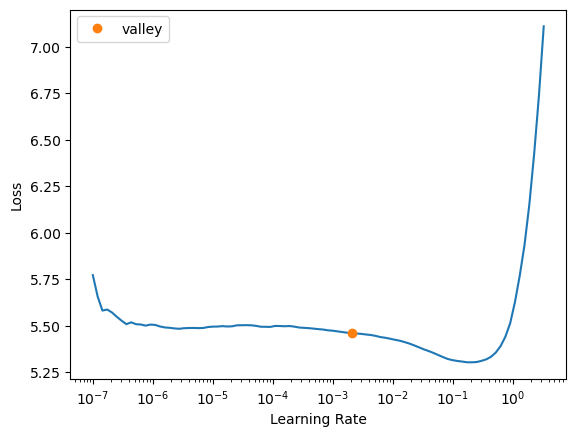

In [13]:
learner.lr_find()

In [14]:
learner.fit_one_cycle(10, 0.003, moms=(0.8,0.7,0.8))

In [15]:
learner.save_encoder(f'finetuned_lstm_{VOCAB_TYPE.name}')

# Train classifier

In [16]:
vocab_file = model_path/f'itos_imdb_{VOCAB_TYPE.name}.pkl'
print(f'Loading vocab from {vocab_file}')
with open(model_path/'itos_imdb_customvocab.pkl', 'rb') as f:
    pretrained_vocab = pickle.load(f)

tok_rules = [
    lowercase,
    fix_html,
    spec_add_spaces,
    rm_useless_spaces,
]
x_tfms = [
    Tokenizer.from_folder(dataset_path, tok=TokenizeWithRules(WordTokenizer(), tok_rules), rules=[]),
    Numericalize(vocab=pretrained_vocab)
]
y_tfms = [
    parent_label,
    Categorize()
]

BROKEN_POS_FILE = dataset_path/'train/pos/1175_9.txt' #sample that breaks training (for unknown reason, might be because it's the larger file)
dataset_files = get_text_files(dataset_path, folders=['train'])
dataset_files.remove(BROKEN_POS_FILE)

splitter = TrainTestSplitter(test_size=0.2, random_state=42)(dataset_files)
dsets = Datasets(dataset_files, [x_tfms, y_tfms], splits=splitter)

Loading vocab from /home/ubuntu/.fastai/data/wt103-fwd/itos_imdb_PRETRAINED.pkl


In [17]:
bs = 256
dloaders = dsets.dataloaders(
    dl_type=SortedDL, 
    before_batch=pad_input, 
    bs=bs, val_bs=bs, 
    drop_last=True, val_drop_last=True, 
    verbose=True
)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: Pad_Input
Setting up after_batch: Pipeline: 


In [18]:
opt_func = partial(Adam, wd=0.1)
learn = text_classifier_learner(dloaders, AWD_LSTM, metrics=[accuracy], drop_mult=0.5, opt_func=opt_func, path=model_path)

In [19]:
learn = learn.load_encoder(f'finetuned_lstm_{VOCAB_TYPE.name}')
learn = learn.to_fp16()

In [20]:
lr = 1e-1 * bs/128
learn.fit_one_cycle(1, lr, moms=(0.8,0.7,0.8))
# learn.fit_one_cycle(1, 2e-5)

In [21]:
learn.freeze_to(-2)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7,0.8), wd=0.1)

In [22]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7,0.8), wd=0.1)

In [23]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7,0.8), wd=0.1)

In [24]:
learn.save_encoder(f'imdb_lstm_{VOCAB_TYPE.name}')

### Evaluate model

In [25]:
test_dataset_files = get_text_files(dataset_path, folders=['test'])
test_dsets = Datasets(dataset_files, [x_tfms, y_tfms])
test_dloaders = test_dsets.dataloaders(
    dl_type=SortedDL, 
    before_batch=pad_input, 
    bs=bs, val_bs=bs, 
    drop_last=True, val_drop_last=True, 
    verbose=True
)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: Pad_Input
Setting up after_batch: Pipeline: 


In [26]:
learn.model.eval()

with torch.no_grad():
    test_preds, test_targets = learn.get_preds(dl=test_dloaders.train)

accuracy(test_preds, test_targets)

TensorBase(0.9526)